# Training Embeddings con GNN
Aca crearemos embeddings paa un grafo de Internet, es decir represenaciones de los SA a partir de la topologia y atributos de los SA.

In [ ]:
# !pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121
# !pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html

In [1]:
%load_ext autoreload
%autoreload 2
# from modules.gnn import GNN
import scipy.sparse as sp
import numpy as np
import os

from modules.graph import Graph, create_files
from modules.gnn import GNN
from modules.gnn_models import GCN, GraphSAGE, GAT

import torch
import torch.nn.functional as F
import dgl

/home/valentina/Desktop/GIT/TrabajoTesis/ennv310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
ls /media/valentina/KINGSTON/TESIS/data/RIBs

rib_abril_2024.txt*            sanitized_rib_enero_2024.txt*
rib_enero_2024.txt*            sanitized_rib_febrero_2024.txt*
rib_marzo_2024.txt*            sanitized_rib_marzo_2024.txt*
sanitized_rib_abril_2024.txt*


In [13]:

DATA_PATH = '/media/valentina/KINGSTON/TESIS'
RELATIONSHIPS_FILE = '/media/valentina/KINGSTON/TESIS/data/CAIDA_AS_Relationships/Serial_1/20220701.as-rel.txt.bz2'
rib_path = '/media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024.txt'

In [15]:
# Definimos las rutas de los archivos
BASE_PATH = os.getcwd() + "/data/"
# RELATIONSHIPS_FILE  = BASE_PATH + "CAIDA_AS_Relationships/Serial_1/20220701.as-rel.txt.bz2"
FEATURES_FILE = BASE_PATH + "node_feature_mio.csv" #"/node_features.csv" 
# rib_path = BASE_PATH + 'sanitized_rib_febrero_2024.txt'
dataset_graph_path = BASE_PATH + 'dgl_graph/'
MAX_NUM_ROUTES = 6000000

## Creacion Grafo 
Creamos un grafo nx y dgl, ademas de los archivos edges.csv y nodes.csv a partir de archivos ribs previamente creados o de archivo CAIDA AS Relationships.

Crear esos archivos una unica vez con create_graph() una ves ya creados los archivos edges.csv y nodes.csv puedo ocupar directamente la funcion 

Se le puede indicar el maximo de bgp paths que se quiere (hehco para cuando se leen ribs no de caida) 

### CASO 1: RIBs
* Creacion de grafo a partir de paths recolectados de las RIBs por BGPStream
* Por ahora le asignamos a todos los nodos embeddings iniciales de de dimension 32 parte con puros 1s todos


In [16]:
# Definimos las listas de features

# features_file = 'node_degrees' #'' # 'node_degrees' # las features que se le agregaran seran 
# features_file = base_path + "/node_features.csv"
FEATURES_FILE = BASE_PATH + "/node_features_mio_febrero.csv"
# FEATURES_FILE = 'node_features_mio_febrero.csv'
attr = 'node_features_mio_febrero.csv' # 'mio_attr' # 'degree' # 'node_features_mio_febrero.csv'
# rib_path = BASE_PATH + 'sanitized_rib_febrero_2024.txt'
MAX_NUM_ROUTES = 6000000
graph_case1 = create_files(
            dataset_graph_path,
            file = rib_path, 
            features_file = FEATURES_FILE, 
            from_caida=False, 
            remove_degree=3,
            debug=True,
            max_paths = MAX_NUM_ROUTES)
print('[NX Graph]',graph_case1.nx_graph)

[CARPETA CREADA]:  /home/valentina/Desktop/GIT/TrabajoTesis/data/dgl_graph/
[Creando topologia desde /media/valentina/KINGSTON/TESIS/data/RIBs/sanitized_rib_febrero_2024.txt]
[NX Graph]:  DiGraph with 42495 nodes and 240581 edges
[Agregando attr a nodos desde /home/valentina/Desktop/GIT/TrabajoTesis/data//node_features_mio_febrero.csv]
[NX Graph]:  DiGraph with 42495 nodes and 240581 edges
[META CREADO]
[NX Graph eliminando]:  DiGraph with 27461 nodes and 225547 edges
[NX Graph eliminando]:  DiGraph with 27178 nodes and 225264 edges
[NX Graph eliminando]:  DiGraph with 27166 nodes and 225252 edges
[NX Graph] DiGraph with 27166 nodes and 225252 edges


### CASO 2: CAIDA Relationships (solo caso prueba)
* Creacion del grafo a partir de CAIDA AS Relationships (AS Rank) 
* Se les da atributos a los edges correspondientes al tipo de relacion que comparten
* Es solo de prueba 

In [ ]:
# Definimos las listas de features

# features_file =  'data/node_features.csv'  #'node_degrees' #'' # 'node_degrees' # las features que se le agregaran seran 
# FEATURES_FILE = BASE_PATH + "node_features_mio.csv" 

# graph_case1 = create_files(
#              dataset_graph_path,
#              RELATIONSHIPS_FILE, 
#              FEATURES_FILE, 
#              from_caida=True, 
#              remove_degree=0,
#              debug=True,
# max_paths = None)
 
# print('[NX Graph]',graph_case1.nx_graph)

## Link Prediction: Encode-Decoder 

In [6]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.data import CoraGraphDataset
from dgl.dataloading import negative_sampler
import dgl.function as fn
import numpy as np
import scipy.sparse as sp
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import os

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


In [5]:
def compute_auc(pos_score,neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)


def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return F.binary_cross_entropy_with_logits(scores, labels)


def plot_roc_with_distributions(pos_score, neg_score,model_name):
    # Convertir tensores a NumPy
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([
        torch.ones(pos_score.shape[0]),
        torch.zeros(neg_score.shape[0])
    ]).numpy()

    # Calcular ROC y AUC
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc = roc_auc_score(labels, scores)

    # Calcular umbral óptimo (punto más cercano a (0,1))
    distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
    optimal_idx = np.argmin(distances)
    optimal_threshold = thresholds[optimal_idx]
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]

    # Crear figura con 2 subplots
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Subplot 1: distribuciones de scores
    ax[0].hist(pos_score.numpy(), bins=50, alpha=0.5, label='Positive Scores', color='skyblue')
    ax[0].hist(neg_score.numpy(), bins=50, alpha=0.5, label='Negative Scores', color='salmon')
    ax[0].axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {optimal_threshold:.2f}')
    ax[0].set_title('Distributions of Predicted Scores')
    ax[0].set_xlabel('Score')
    ax[0].set_ylabel('Frequency')
    ax[0].legend()

    # Subplot 2: curva ROC
    ax[1].plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})', color='blue')
    ax[1].plot([0, 1], [0, 1], 'k--', label='Random guess')
    ax[1].scatter(optimal_fpr, optimal_tpr, color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver Operating Characteristic (ROC)')
    ax[1].legend(loc='lower right')
    ax[1].grid(True)

    # Mostrar todo
    plt.tight_layout()
    plt.savefig(f'results/graficos/roc/roc_curve_{model_name}.png')
    plt.show()

    print(f"AUC: {auc:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")

    return optimal_threshold


### CASO 1: 
* Encoder : GNN -> (GCN , GraphSAGE, GAT)
* Decoder : DotProduct

In [6]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

In [7]:
gnn = GNN(debug=True)
gnn.load_dataset(dataset_graph_path, force_reload=True)

print('[ATTR SHAPE]: ',gnn.dgl_graph.ndata['feat'].shape)
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
# gnn.split_graph_edges(0.8)
gnn.split_graph_edges_basic(0.8)

Done saving data into cached files.
Graph(num_nodes=27166, num_edges=225252,
      ndata_schemes={'feat': Scheme(shape=(67,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.float32)})
[ATTR SHAPE]:  torch.Size([27166, 67])
Generando 225252 aristas negativas...
Aristas negativas generadas: 225251


Training model: GCN
In epoch 0, loss: 0.6844751238822937
In epoch 10, loss: 0.6714408993721008
In epoch 20, loss: 0.65290367603302
In epoch 30, loss: 0.6277600526809692
In epoch 40, loss: 0.5957850813865662
In epoch 50, loss: 0.5602982640266418
In epoch 60, loss: 0.5264501571655273
In epoch 70, loss: 0.4970504343509674
In epoch 80, loss: 0.4730953276157379
In epoch 90, loss: 0.45591163635253906
AUC 0.8865088353343133


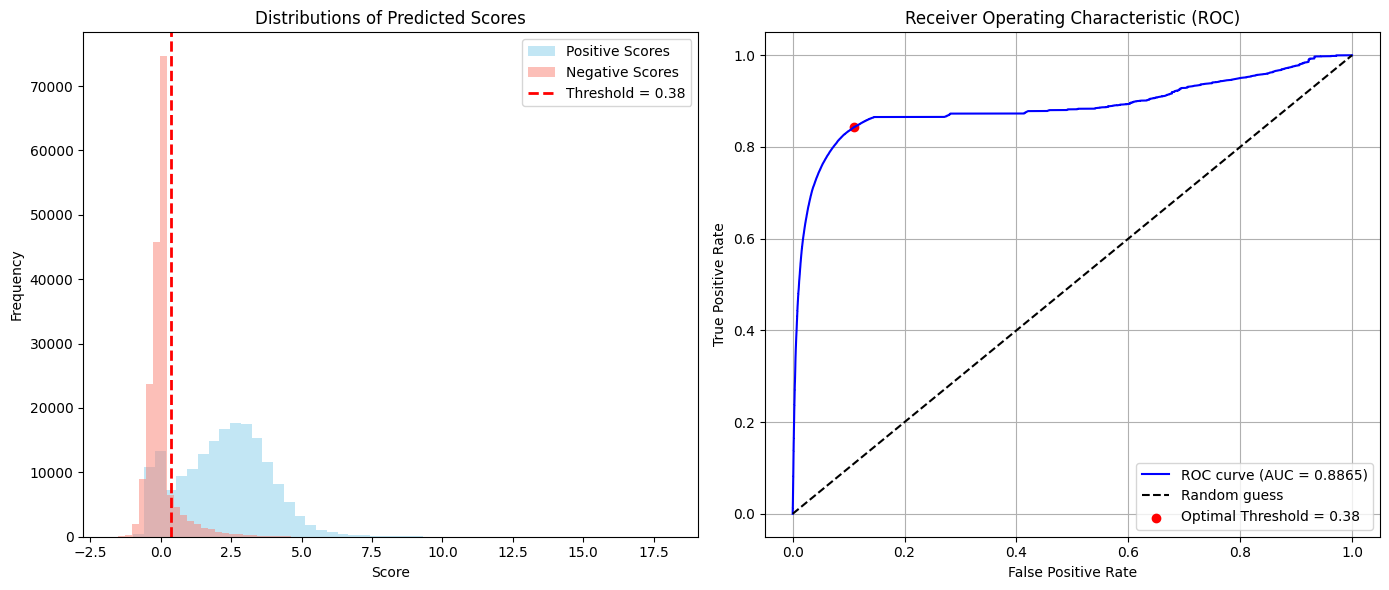

AUC: 0.8865
Optimal Threshold: 0.3757
Training model: GraphSAGE
In epoch 0, loss: 5.053856372833252
In epoch 10, loss: 2.9091694355010986
In epoch 20, loss: 1.6345007419586182
In epoch 30, loss: 1.0289814472198486
In epoch 40, loss: 0.7589730620384216
In epoch 50, loss: 0.6269566416740417
In epoch 60, loss: 0.5551579594612122
In epoch 70, loss: 0.5113601088523865
In epoch 80, loss: 0.48230984807014465
In epoch 90, loss: 0.4618176519870758
AUC 0.8310664965860957


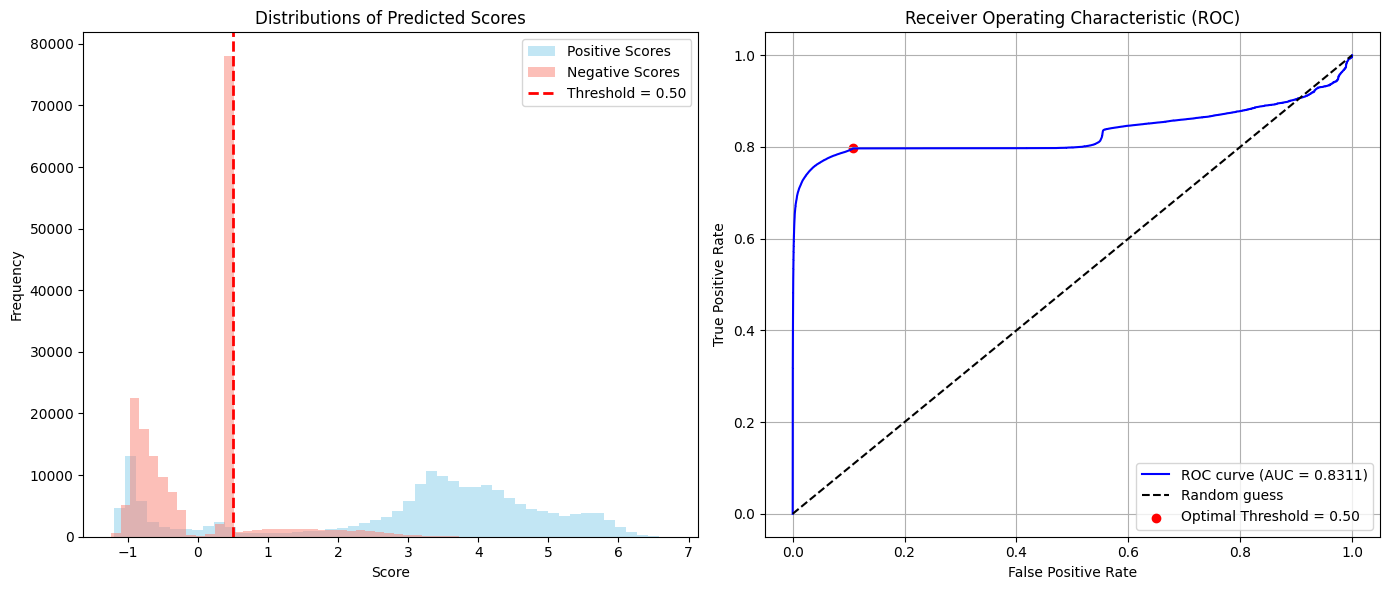

AUC: 0.8311
Optimal Threshold: 0.4976
Training model: GAT
In epoch 0, loss: 0.5009506344795227
In epoch 10, loss: 0.47110357880592346
In epoch 20, loss: 0.4512406885623932
In epoch 30, loss: 0.4374321401119232
In epoch 40, loss: 0.4283778667449951
In epoch 50, loss: 0.422728031873703
In epoch 60, loss: 0.41951096057891846
In epoch 70, loss: 0.41771939396858215
In epoch 80, loss: 0.4163670539855957
In epoch 90, loss: 0.415130078792572
AUC 0.8294528529886737


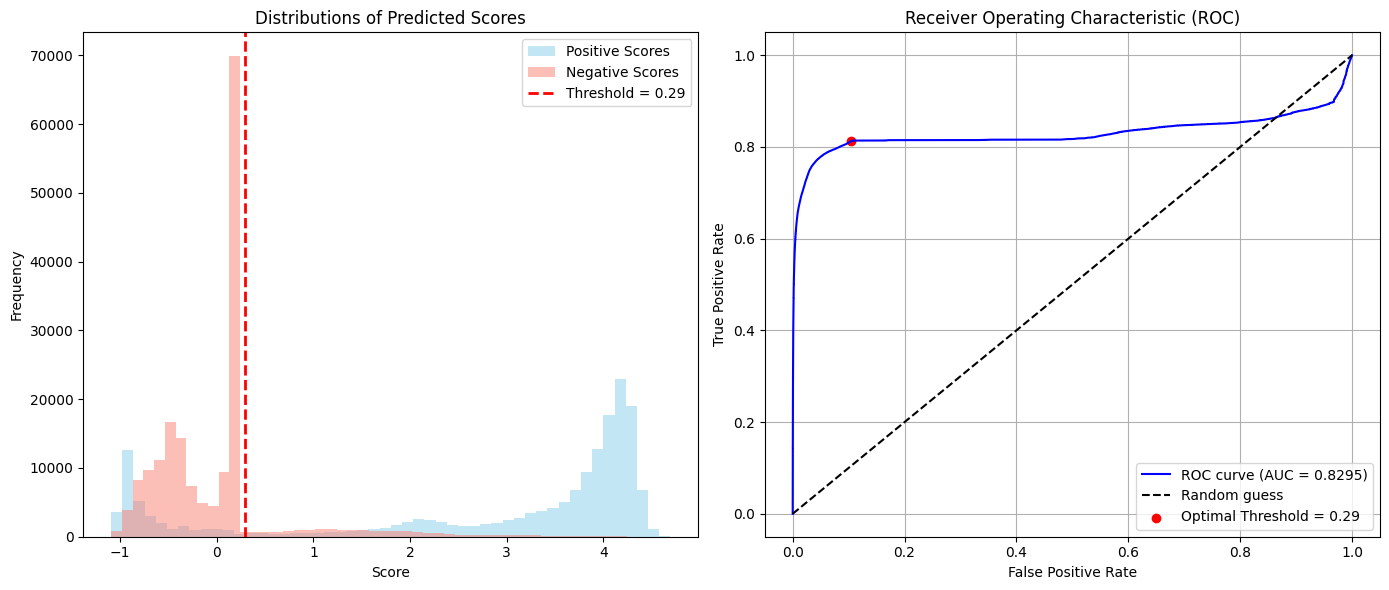

AUC: 0.8295
Optimal Threshold: 0.2915


In [8]:
decoder = 'DotProduct'
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats = 64 
out_feats = 32
out_feats_mlp = 1

for model_name in models:

    print("Training model: {}".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # ----------- training -------------------------------- #

    all_logits = []
    for e in range(100):

        # forward
        model.train()
        h = model.encode(gnn.train_g, gnn.train_g.ndata["feat"])

        pos_score = model.decodeDotProduct(gnn.train_pos_g, h)
        neg_score = model.decodeDotProduct(gnn.train_neg_g, h)


        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 10 == 0:
            print("In epoch {}, loss: {}".format(e, loss))
    
    # with torch.no_grad():
    #     plot_roc_with_distributions(pos_score, neg_score)

    # ----------- 5. check results ------------------------ #


    with torch.no_grad():
        pos_score = model.decodeDotProduct(gnn.test_pos_g, h)
        neg_score = model.decodeDotProduct(gnn.test_neg_g, h)
        print("AUC", compute_auc(pos_score, neg_score))
        plot_roc_with_distributions(pos_score, neg_score,model_name+'_'+decoder+'_'+attr) 
    
    # Guaradar el modelo
    torch.save(model.state_dict(), f'data/model_emb_{model_name}_{attr}.pth')

    # Guardar los embeddings
    torch.save(h, f"data/embeddings/embeddings_ribs_DP_{model_name}_{attr}.pt")

### CASO 2: 
* Encoder : GNN
* Decoder : MLP

In [9]:
gnn = GNN(debug=True)
gnn.load_dataset(dataset_graph_path, force_reload=True)

print('[ATTR SHAPE]: ',gnn.dgl_graph.ndata['feat'].shape)

gnn.split_graph_edges_basic(train_size=0.8)

Done saving data into cached files.
Graph(num_nodes=42495, num_edges=225252,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.float32)})
[ATTR SHAPE]:  torch.Size([42495, 2])
Generando 225252 aristas negativas...
Aristas negativas generadas: 225251


Training model: GCN
In epoch 0, loss: 0.6891065835952759
In epoch 10, loss: 0.5138819813728333
In epoch 20, loss: 0.17921613156795502
In epoch 30, loss: 0.1501787155866623
In epoch 40, loss: 0.12459726631641388
In epoch 50, loss: 0.11127915978431702
In epoch 60, loss: 0.10437081754207611
In epoch 70, loss: 0.0984765887260437
In epoch 80, loss: 0.0930900052189827
In epoch 90, loss: 0.08860542625188828
AUC 0.9699172880065278


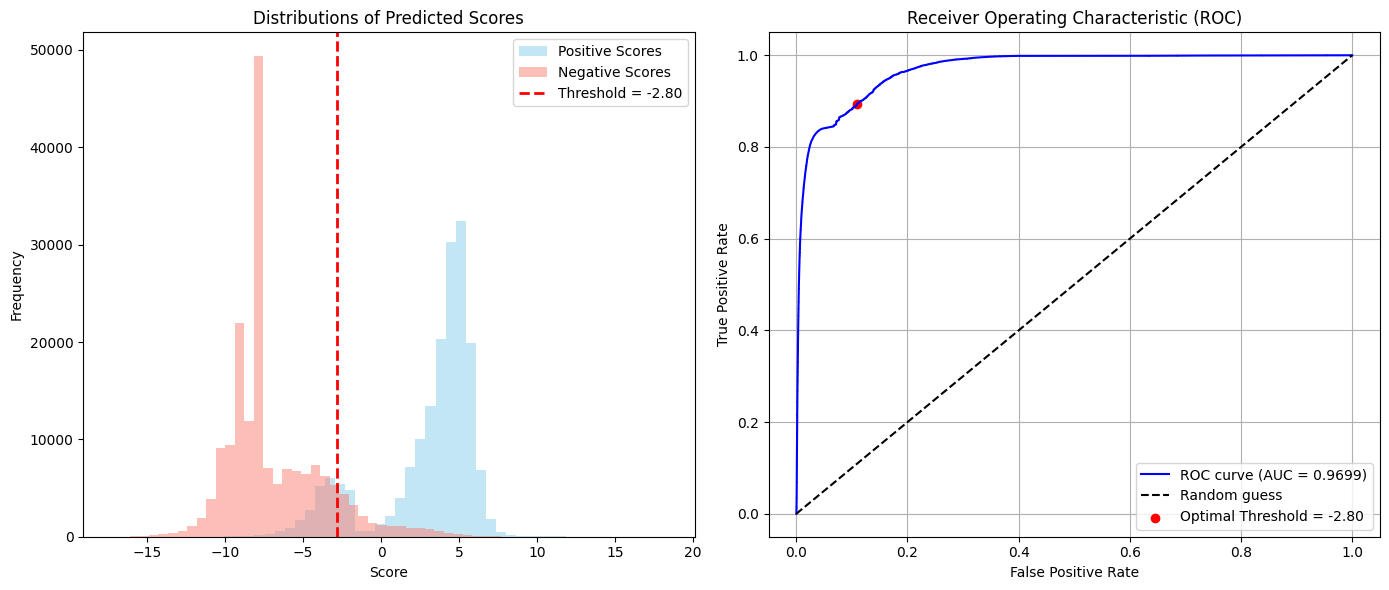

AUC: 0.9699
Optimal Threshold: -2.7993
Training model: GraphSAGE
In epoch 0, loss: 0.6459865570068359
In epoch 10, loss: 0.24082975089550018
In epoch 20, loss: 0.1249300166964531
In epoch 30, loss: 0.07764380425214767
In epoch 40, loss: 0.05472281202673912
In epoch 50, loss: 0.04092592000961304
In epoch 60, loss: 0.03721308335661888
In epoch 70, loss: 0.0355413518846035
In epoch 80, loss: 0.03399234637618065
In epoch 90, loss: 0.03307580575346947
AUC 0.9516516045129929


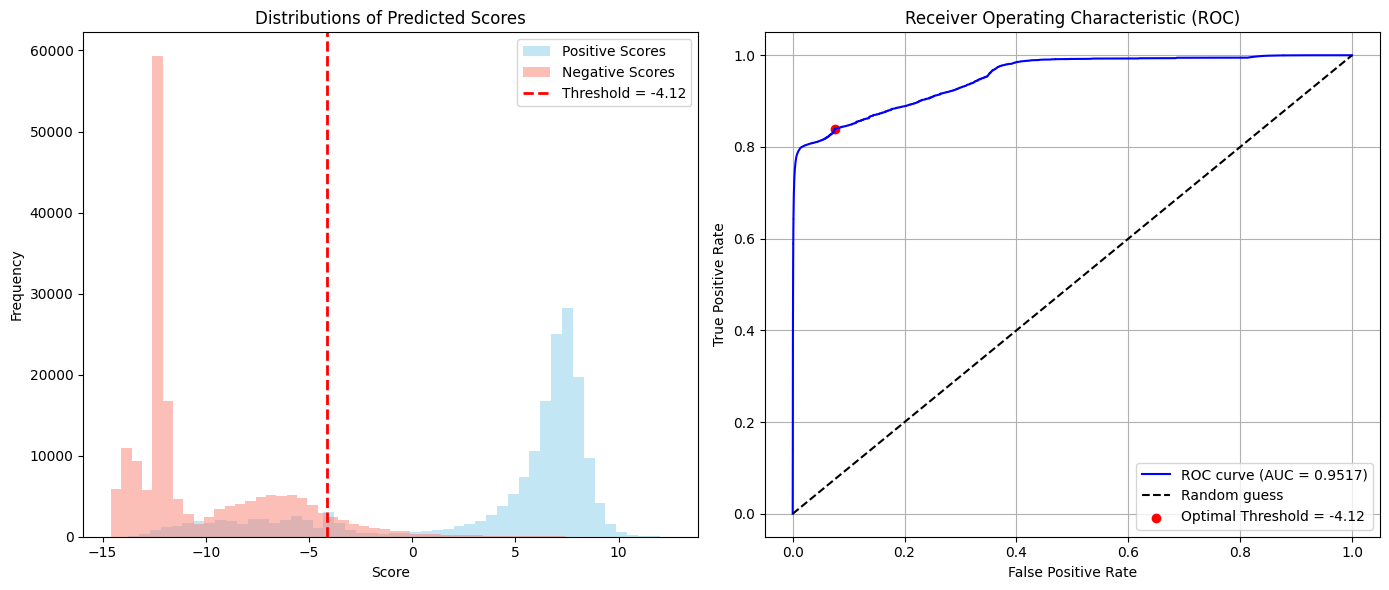

AUC: 0.9517
Optimal Threshold: -4.1211
Training model: GAT
In epoch 0, loss: 0.6991109848022461
In epoch 10, loss: 0.4433712661266327
In epoch 20, loss: 0.17575770616531372
In epoch 30, loss: 0.1605404019355774
In epoch 40, loss: 0.1294054388999939
In epoch 50, loss: 0.11775730550289154
In epoch 60, loss: 0.1095200851559639
In epoch 70, loss: 0.10194240510463715
In epoch 80, loss: 0.0940135270357132
In epoch 90, loss: 0.08716574311256409
AUC 0.9388397466471606


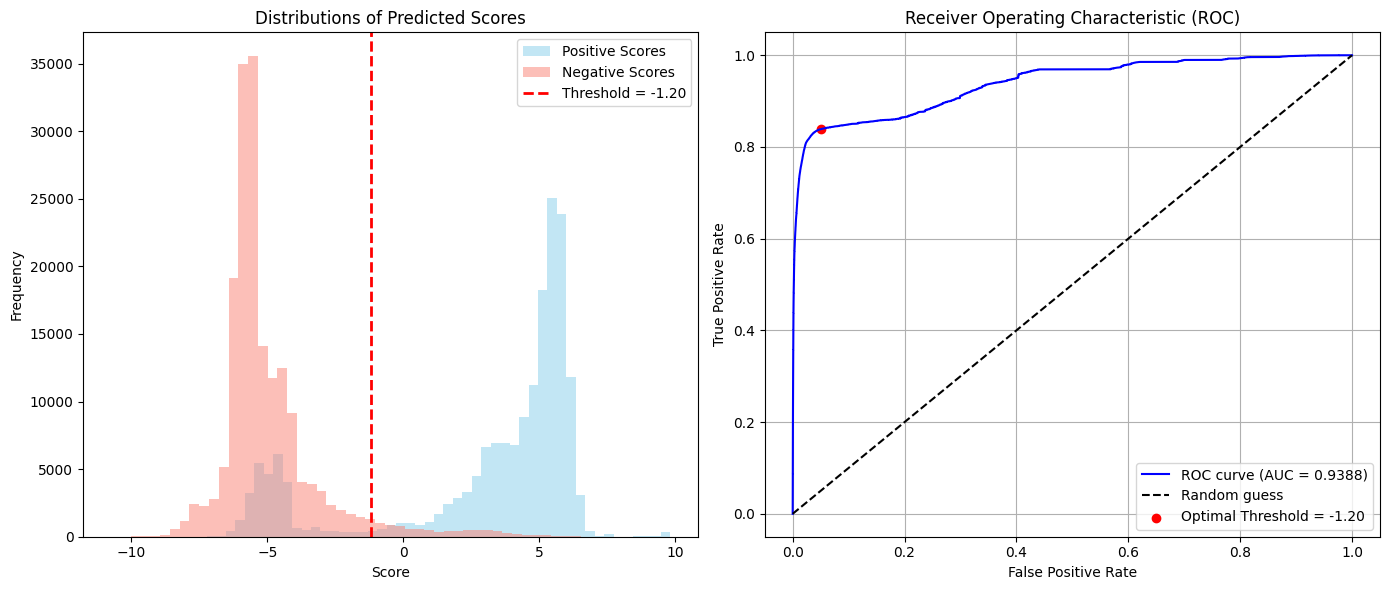

AUC: 0.9388
Optimal Threshold: -1.1978


In [14]:
decoder = 'MLP'
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats = 32 
out_feats = 16

for model_name in models:

    print("Training model: {}".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats )
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # ----------- training -------------------------------- #

    all_logits = []
    for e in range(100):

        # forward
        model.train()
        h = model.encode(gnn.train_g, gnn.train_g.ndata["feat"])

        pos_score = model.decodeMLP(gnn.train_pos_g, h)
        neg_score = model.decodeMLP(gnn.train_neg_g, h)


        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 10 == 0:
            print("In epoch {}, loss: {}".format(e, loss))

    # ----------- check results ------------------------ #
    from sklearn.metrics import roc_auc_score

    with torch.no_grad():
        pos_score = model.decodeMLP(gnn.test_pos_g, h)
        neg_score = model.decodeMLP(gnn.test_neg_g, h)
        print("AUC", compute_auc(pos_score, neg_score))
        plot_roc_with_distributions(pos_score, neg_score,model_name+'_'+decoder+'_'+attr)
    # Guaradar el modelo
    torch.save(model.state_dict(), f'data/model_emb_{model_name}_{attr}.pth')

    # Guardar los embeddings
    torch.save(h, f"data/embeddings/embeddings_ribs_MLP_{model_name}_{attr}.pt")
    

In [13]:
# Se incluyen los parametros tanto de MLP como de la GNN

for name, param in model.named_parameters():
    print(name, param.shape)


conv1.fc_neigh.weight torch.Size([16, 69])
conv1.fc_self.weight torch.Size([16, 69])
conv1.fc_self.bias torch.Size([16])
conv2.fc_neigh.weight torch.Size([16, 16])
conv2.fc_self.weight torch.Size([16, 16])
conv2.fc_self.bias torch.Size([16])
decoder.W1.weight torch.Size([16, 32])
decoder.W1.bias torch.Size([16])
decoder.W2.weight torch.Size([1, 16])
decoder.W2.bias torch.Size([1])


# 
De aqui en adelante pruebas desordenado!

## Inferencia valor PAgeRank


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl

class GNNPredictLastFeat(nn.Module):
    def __init__(self, in_feats, hidden_feats):
        super().__init__()
        self.conv1 = dgl.nn.GraphConv(in_feats, hidden_feats)
        self.conv2 = dgl.nn.GraphConv(hidden_feats, hidden_feats)
        self.regressor = nn.Linear(hidden_feats, 1)  # solo predice 1 número por nodo

    def forward(self, g, features):
        h = F.relu(self.conv1(g, features))
        h = F.relu(self.conv2(g, h))
        out = self.regressor(h)  # predicción de un valor
        return out.squeeze(-1)   # tamaño [n_nodos]


In [6]:
gnn = GNN(debug=True)
gnn.load_dataset(dataset_graph_path, force_reload=True)


Done saving data into cached files.
Graph(num_nodes=42242, num_edges=132717,
      ndata_schemes={'feat': Scheme(shape=(67,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.float32)})


In [7]:
# Quitar valor a inferir
feats = gnn.dgl_graph.ndata['feat']
targets = feats[:, -1]
new_feats = feats[:, :-1]

gnn.dgl_graph.ndata['feat'] = new_feats
gnn.dgl_graph = dgl.add_self_loop(gnn.dgl_graph) # FIXME:

gnn.split_graph_nodes(train_size=0.8)

                                

In [8]:

train_mask = gnn.dgl_graph.train_mask
test_mask = gnn.dgl_graph.test_mask

print(train_mask)
print(test_mask)

tensor([ True, False,  True,  ...,  True, False, False])
tensor([False,  True, False,  ..., False,  True,  True])


In [9]:
# -------------- Entrenamiento ------------------ #
import torch.optim as optim

# Creamos el modelo
model = GNNPredictLastFeat(in_feats=gnn.dgl_graph.ndata['feat'].shape[1], hidden_feats=64)

# Forward pass


optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()  # Porque es regresión

for epoch in range(40):
    model.train()
    logits = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])  # predictions.shape = [n_nodes]
    loss = F.mse_loss(logits[train_mask], targets[train_mask])    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# model.eval()
# with torch.no_grad():
#     pred = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
    
#     pred = (pred[test_mask] > 0.5).float()  # Convertir a 0 o 1
#     acc = (pred == targets[test_mask]).float().mean()
#     print(f"Test Accuracy: {acc.item():.4f}")


Epoch 0: Loss = 0.0856
Epoch 1: Loss = 0.0706
Epoch 2: Loss = 0.0611
Epoch 3: Loss = 0.0518
Epoch 4: Loss = 0.0464
Epoch 5: Loss = 0.0464
Epoch 6: Loss = 0.0487
Epoch 7: Loss = 0.0474
Epoch 8: Loss = 0.0439
Epoch 9: Loss = 0.0415
Epoch 10: Loss = 0.0410
Epoch 11: Loss = 0.0413
Epoch 12: Loss = 0.0411
Epoch 13: Loss = 0.0400
Epoch 14: Loss = 0.0384
Epoch 15: Loss = 0.0373
Epoch 16: Loss = 0.0369
Epoch 17: Loss = 0.0368
Epoch 18: Loss = 0.0359
Epoch 19: Loss = 0.0344
Epoch 20: Loss = 0.0334
Epoch 21: Loss = 0.0329
Epoch 22: Loss = 0.0326
Epoch 23: Loss = 0.0316
Epoch 24: Loss = 0.0304
Epoch 25: Loss = 0.0296
Epoch 26: Loss = 0.0292
Epoch 27: Loss = 0.0284
Epoch 28: Loss = 0.0274
Epoch 29: Loss = 0.0270
Epoch 30: Loss = 0.0266
Epoch 31: Loss = 0.0258
Epoch 32: Loss = 0.0254
Epoch 33: Loss = 0.0252
Epoch 34: Loss = 0.0246
Epoch 35: Loss = 0.0242
Epoch 36: Loss = 0.0240
Epoch 37: Loss = 0.0234
Epoch 38: Loss = 0.0232
Epoch 39: Loss = 0.0228


In [184]:
model.eval()
with torch.no_grad():
    preds = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])

mse = F.mse_loss(preds[test_mask], targets[test_mask]).item()
print(f"Test MSE: {mse:.4f}")


Test MSE: 0.0000


In [185]:
gnn.dgl_graph.ndata['feat'].shape

torch.Size([36580, 68])

In [186]:
# Guaradar el modelo
torch.save(model.state_dict(), 'data/model_emb.pth')

# Guardar los embeddings
torch.save(h, "data/embeddings_ribs_PageRank.pt")

# Crear Embeddings otros

## DeepWalk

In [10]:
from dgl.nn import DeepWalk
from torch.utils.data import DataLoader
from torch.optim import SparseAdam

In [11]:
gnn = GNN(debug=True)
gnn.load_dataset(dataset_graph_path, force_reload=True)

Done saving data into cached files.
Graph(num_nodes=42242, num_edges=132717,
      ndata_schemes={'feat': Scheme(shape=(67,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.float32)})


In [ ]:
emb = DeepWalk(gnn.dgl_graph,
               emb_dim=32,        # tamaño del embedding
               walk_length=6,     # número de saltos por walk
            #    context_size=5,     # tamaño de la ventana de contexto
            #    walks_per_node=10,  # número de walks por nodo
            #    num_negative=5
               )     # número de negativos por positivo

emb = DeepWalk(gnn.dgl_graph)



dataloader = DataLoader(torch.arange(gnn.dgl_graph.num_nodes()),
                        batch_size=500,
                        shuffle=True, 
                        collate_fn=emb.sample,)

optimizer = SparseAdam(emb.parameters(), lr=0.01)

num_epochs = 1

for epoch in range(num_epochs):
    for batch_walk in dataloader:
        # print("[BATCH]",batch_walk )
        loss = emb(batch_walk)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        


h = emb.node_embed.weight.detach()
print("SHAPE",h.shape)
print("EMBEDDINGS",h)




IndexError: index out of range in self

In [26]:
# ✅ Correcto
emb = DeepWalk(gnn.dgl_graph,
               emb_dim=32,
               walk_length=4,
               window_size=2)

dataloader = DataLoader(torch.arange(gnn.dgl_graph.num_nodes()),
                        batch_size=300,
                        shuffle=True, 
                        collate_fn=emb.sample,)

optimizer = SparseAdam(emb.parameters(), lr=0.01)

num_epochs = 1

for epoch in range(num_epochs):
    for batch_walk in dataloader:
        # print("[BATCH]",batch_walk )
        loss = emb(batch_walk)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

IndexError: index out of range in self

In [67]:
h = emb.node_embed.weight.detach()
print("SHAPE",h.shape)
print("EMBEDDINGS",h)

SHAPE torch.Size([36580, 128])
EMBEDDINGS tensor([[-0.1586, -0.1637,  0.1585,  ...,  0.1625, -0.1555,  0.1694],
        [-0.2038, -0.1939,  0.2022,  ...,  0.1929, -0.1953,  0.1814],
        [-0.1803, -0.1698,  0.1698,  ...,  0.1676, -0.1702,  0.1691],
        ...,
        [-0.0862, -0.0907,  0.0921,  ...,  0.0857, -0.0850,  0.0945],
        [-0.1030, -0.1055,  0.1089,  ...,  0.0963, -0.1074,  0.0997],
        [-0.0967, -0.0872,  0.0959,  ...,  0.0849, -0.0953,  0.0819]])


In [68]:
# Guardar los embeddings
torch.save(h, "data/embeddings_deepWalk.pt")

## PageRank

In [ ]:
gnn = GNN(debug=True)
gnn.load_dataset(dataset_graph_path, force_reload=True)

Done saving data into cached files.
Graph(num_nodes=36580, num_edges=315774,
      ndata_schemes={'feat': Scheme(shape=(74,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.float32)})
[ATTR SHAPE]:  torch.Size([36580, 74])
Generando 315774 aristas negativas...
Aristas negativas generadas: 315773


In [74]:
# ----------- 2. Run PageRank for Graph -------------- #
N = gnn.dgl_graph.number_of_nodes()
DAMP = 0.85
K = 10


def compute_pagerank(g):
    g.ndata["pv"] = torch.ones(N) / N
    degrees = g.out_degrees(g.nodes()).type(torch.float32)
    for k in range(K):
        g.ndata["pv"] = g.ndata["pv"] / degrees
        g.update_all(
            message_func=fn.copy_u(u="pv", out="m"),
            reduce_func=fn.sum(msg="m", out="pv"),
        )
        g.ndata["pv"]  = (1 - DAMP) / N + DAMP * g.ndata["pv"]
    g.ndata["pv"]  = g.ndata["pv"].unsqueeze(1)
    return g.ndata["pv"]


pv = compute_pagerank(gnn.dgl_graph)
gnn.dgl_graph.ndata["h"] = pv  # Inicializa características del nodo

print(gnn.dgl_graph.ndata["h"])

tensor([[1.5807e-05],
        [1.7451e-05],
        [2.1136e-05],
        ...,
        [4.1371e-06],
        [4.3104e-06],
        [4.2975e-06]])


In [77]:
h = gnn.dgl_graph.ndata["h"]
torch.save(h, "data/embeddings_pageRank.pt")

# Node2Vec (2016)

* Surge con el fin de generalizar DeepWalk.
* Node2Vec emplea caminos aleatorios de segundo orden, pues se basa en probabilidades de transición de nodo-a-nodo-a-nodo (o vértice-a-vértice). Es decir, avanzar hacia un nodo determinado no viene sólo dado por el nodo en el que nos encontremos, sino también por el nodo anterior de donde vengamos.

* Se apoyan en el mismo concepto que plantea word2vec
* De igual manera que word2vec busca estimar la probabilidad de ocurrencia de una palabra en una frase, dadas las palabras cercanas

Node2Vec es una mejora de DeepWalk. También genera caminatas y usa Word2Vec, pero:
    Introduce dos parámetros:
        pp: controla la probabilidad de volver atrás (tipo DFS).

        qq: controla la probabilidad de explorar localmente (tipo BFS).

    Así, Node2Vec puede balancear entre exploración profunda (estructural) y local (de vecindad).

Esto permite obtener embeddings que capturan diferentes tipos de relaciones:

    Parecidos en rol (ej: puentes entre comunidades).

    Parecidos en vecindad (ej: miembros de la misma comunidad).

In [6]:
ls /home/valentina/

Desktop/    Downloads/  Pictures/  snap/          typst-linux.tar.gz
Documents/  Music/      Public/    TrabajoTesis/  Videos/


In [ ]:
path_datos = '/run/user/1000/gvfs/google-drive:host=niclabs.cl,user=valentina/0AAr8ir4h6wr-Uk9PVA/1sxbt7IgwLWM4M_vHL8A-mCTIWSclaPXL/172iVXDM8jXz_Yb6bQ0OYXCFKuEQB2aeU'
path_ribs = '/run/user/1000/gvfs/google-drive:host=niclabs.cl,user=valentina/0AAr8ir4h6wr-Uk9PVA/1sxbt7IgwLWM4M_vHL8A-mCTIWSclaPXL/172iVXDM8jXz_Yb6bQ0OYXCFKuEQB2aeU/16LUQ6rzaVUdLlCFi6qi51WN5bgW0mlBQ'

In [14]:
ls /run/user/1000/gvfs/google-drive:host=niclabs.cl,user=valentina/0AAr8ir4h6wr-Uk9PVA/1sxbt7IgwLWM4M_vHL8A-mCTIWSclaPXL/172iVXDM8jXz_Yb6bQ0OYXCFKuEQB2aeU/16LUQ6rzaVUdLlCFi6qi51WN5bgW0mlBQ/

1ciunKdqAC56ifD52jouamen5xX4MbUjN  1U5gLQU4PUDhPXD1inGeRVGedsFL97l-A
1LIiuCk37EY4e6jP5pGPvp984SK4Z5oXh  1WrVRSefy2_X5X09VPfGy6JWhr6hu9_ZX
1mIy_xXyHhFUvByeQ1salMfJrgygUbtbX  1z_qrW-vd56s0xdviTyhTEhCIlTEzvd5k
1MJ57oePUxeFr-I43f9qIx18A4nz_l4yu


In [9]:
ls /run/user/1000/gvfs/google-drive:host=niclabs.cl,user=valentina/0AAr8ir4h6wr-Uk9PVA/1sxbt7IgwLWM4M_vHL8A-mCTIWSclaPXL/172iVXDM8jXz_Yb6bQ0OYXCFKuEQB2aeU/16LUQ6rzaVUdLlCFi6qi51WN5bgW0mlBQ



SyntaxError: invalid decimal literal (1492353726.py, line 1)